In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision.models import ResNet101_Weights
from torchvision.models import resnet101
import cv2
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
train_data_path = '/data/train'
test_data_path = '/data/test'

In [4]:
hotdog_path = os.path.join(train_data_path, 'hotdog')
not_hotdog_path = os.path.join(train_data_path, 'nothotdog')

In [5]:
hotdog_images = []
not_hotdog_images = []
for image_path in os.listdir(hotdog_path):
    hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(hotdog_path, image_path)), cv2.COLOR_BGR2RGB))
for image_path in os.listdir(not_hotdog_path):
    not_hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(not_hotdog_path, image_path)), cv2.COLOR_BGR2RGB))

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Resize(256),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
hotdog_train, hotdog_val = train_test_split(hotdog_images, test_size=0.2, random_state=42)
not_hotdog_train, not_hotdog_val = train_test_split(not_hotdog_images, test_size=0.2, random_state=42)
train_data = [(transform(image), 1) for image in hotdog_train]
val_data = [(transform(image), 1) for image in hotdog_val]
train_data.extend([(transform(image), 0) for image in not_hotdog_train])
val_data.extend([(transform(image), 0) for image in not_hotdog_val])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [9]:
model = resnet101(weights=ResNet101_Weights.DEFAULT) #Pretrained ResNet101
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2) #Changing the number of outputs to 2

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 152MB/s]  


'cuda:0'

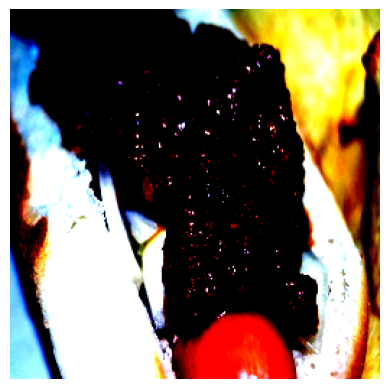

tensor(1)


In [10]:
for images, label in train_loader:
    first_image = images[0].numpy()
    plt.imshow(np.transpose(first_image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    print(label[0])
    break

In [11]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9) #Adam showed worse metrics by about 0.1
criterion = nn.CrossEntropyLoss()
epochs = 20

# Model training loop

In [12]:
loss_val_arr = []
loss_train_arr = []
gc.collect()
torch.cuda.empty_cache()
for e in range(epochs):
    train_loss_run = 0.0
    val_loss = 0.0
    model.train()
    for images, labels in train_loader:
        torch.cuda.empty_cache()
        images.to(device)
        labels.to(device)
        if device == 'cuda:0':
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels.long())
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        train_loss_run += loss.item()
    
    gc.collect()
    sum_of_accuracy = 0.0
    sum_of_precision = 0.0
    sum_of_recall = 0.0
    sum_of_f1_score = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            torch.cuda.empty_cache()
            images.to(device)
            labels.to(device)
            if device == 'cuda:0':
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = criterion(output, labels.long())
            _, predicted = torch.max(output, 1)
            conf_matrix = confusion_matrix(labels.cpu(), predicted.cpu())
            TP = conf_matrix[1][1]
            TN = conf_matrix[0][0]
            FP = conf_matrix[0][1]
            FN = conf_matrix[1][0]
            
            accuracy = (TP + TN) / (TP + TN + FP + FN)
            precision = TP / (TP + FP) if TP + FP != 0 else 0
            recall = TP / (TP + FN) if TP + FN != 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
        
            sum_of_accuracy += accuracy
            sum_of_precision += precision
            sum_of_recall += recall
            sum_of_f1_score += f1_score

        avg_accuracy = sum_of_accuracy / len(val_loader)
        avg_precision = sum_of_precision / len(val_loader)
        avg_recall = sum_of_recall / len(val_loader)
        avg_f1 = sum_of_f1_score / len(val_loader)
        
        val_loss = loss.item()
        train_loss = train_loss_run / len(train_loader)
        print(f'\nEpoch: {e+1}, Train_loss: {train_loss}, Val_loss: {val_loss}, Accuracy: {avg_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}, F1-score: {avg_f1}')
        loss_val_arr.append(val_loss)
        loss_train_arr.append(train_loss)


Epoch: 1, Train_loss: 0.466535315712293, Val_loss: 0.2247239351272583, Accuracy: 0.9040570175438596, Precision: 0.9067143144636219, Recall: 0.8894848935577305, F1-score: 0.8961889997594411

Epoch: 2, Train_loss: 0.25257648626963297, Val_loss: 0.1487404853105545, Accuracy: 0.9292763157894737, Precision: 0.9507216630526066, Recall: 0.9087429094089515, F1-score: 0.927145101886933

Epoch: 3, Train_loss: 0.16784909750024476, Val_loss: 0.17904585599899292, Accuracy: 0.9380482456140351, Precision: 0.9492222090910373, Recall: 0.920452076574775, F1-score: 0.933428565022332

Epoch: 4, Train_loss: 0.12301314905285836, Val_loss: 0.0615413673222065, Accuracy: 0.9336622807017543, Precision: 0.9490868780342465, Recall: 0.9204483438636935, F1-score: 0.9322908505649564

Epoch: 5, Train_loss: 0.08767584405839443, Val_loss: 0.08446068316698074, Accuracy: 0.9435307017543859, Precision: 0.9536114985805388, Recall: 0.9345628325198961, F1-score: 0.942493606889598

Epoch: 6, Train_loss: 0.06651680901646614, 

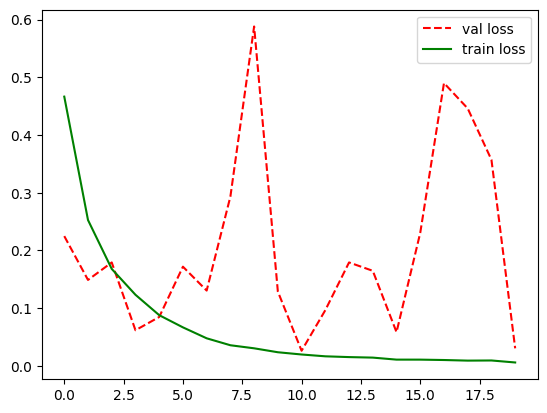

In [17]:
#Graphs of loss function changes
plt.plot(loss_val_arr, "r--", label="val loss")
plt.plot(loss_train_arr, "g", label="train loss")
plt.legend()
plt.show()

In [18]:
torch.save(model.state_dict(), '/kaggle/working/hotdogs_resnet101_SGD.pth')

In [19]:
images = {}
test_hotdog_images = []
test_not_hotdog_images = []
test_hotdog_path = os.path.join(test_data_path, 'hotdog')
test_not_hotdog_path = os.path.join(test_data_path, 'nothotdog')

# Model testing

In [20]:
for image_path in os.listdir(test_hotdog_path):
    test_hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(test_hotdog_path, image_path)), cv2.COLOR_BGR2RGB))
for image_path in os.listdir(test_not_hotdog_path):
    test_not_hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(test_not_hotdog_path, image_path)), cv2.COLOR_BGR2RGB))
test_data = [(transform(image), 1) for image in test_hotdog_images]
test_data.extend([(transform(image), 0) for image in test_not_hotdog_images])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [21]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [24]:
sum_of_accuracy = 0.0
sum_of_precision = 0.0
sum_of_recall = 0.0
sum_of_f1_score = 0.0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        torch.cuda.empty_cache()
        images.to(device)
        labels.to(device)
        if device == 'cuda:0':
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        _, predicted = torch.max(output, 1)
        conf_matrix = confusion_matrix(labels.cpu(), predicted.cpu())
        TP = conf_matrix[1][1]
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if TP + FP != 0 else 0
        recall = TP / (TP + FN) if TP + FN != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
        
        sum_of_accuracy += accuracy
        sum_of_precision += precision
        sum_of_recall += recall
        sum_of_f1_score += f1_score
        print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1_score: {f1_score}')
        
    avg_accuracy = sum_of_accuracy / len(test_loader)
    avg_precision = sum_of_precision / len(test_loader)
    avg_recall = sum_of_recall / len(test_loader)
    avg_f1 = sum_of_f1_score / len(test_loader)
    print(f'\n\nAverage Accuracy: {avg_accuracy}, Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')

Accuracy: 0.96875, Precision: 0.9166666666666666, Recall: 1.0, F1_score: 0.9565217391304348
Accuracy: 0.96875, Precision: 1.0, Recall: 0.9166666666666666, F1_score: 0.9565217391304348
Accuracy: 0.90625, Precision: 0.9333333333333333, Recall: 0.875, F1_score: 0.9032258064516129
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1_score: 1.0
Accuracy: 0.96875, Precision: 1.0, Recall: 0.9333333333333333, F1_score: 0.9655172413793104
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1_score: 1.0
Accuracy: 0.9375, Precision: 1.0, Recall: 0.8823529411764706, F1_score: 0.9375
Accuracy: 0.96875, Precision: 1.0, Recall: 0.9333333333333333, F1_score: 0.9655172413793104
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1_score: 1.0
Accuracy: 0.90625, Precision: 0.9375, Recall: 0.8823529411764706, F1_score: 0.9090909090909091
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1_score: 1.0
Accuracy: 0.96875, Precision: 1.0, Recall: 0.9285714285714286, F1_score: 0.962962962962963
Accuracy: 0.90625, Precision: 1.0, Recall